In [1]:
#%reset -f -s
%matplotlib inline
'''------------------------------------------------------------------
MA-eR-PINN: eRange Prediction using Physics-Informed Neural Networks
---------------------------------------------------------------------
Version: V2.0      Modified: 12.01.2025        William Siegle
---------------------------------------------------------------------
PTRAIN - Standard Pipeline Framework for Training the PINN
+ OPTUNA - Hyperparameter Optimization using Optuna
------------------------------------------------------------------''';

In [2]:
# MA-eR-PINN: CONFIGURATION FILE -------------------------------------------------
from pathlib import Path
CONFIG = {
    # SYSTEM: ---------------------------------------------------------------------
    "GPU_SELECT":       0,
    "ROOT":             Path('../..').resolve(),
    "INPUT_LOCATION":   Path("TripSequences", "trips_processed_pinn_4"), 
    "OUTPUT_LOCATION":  Path("src", "models", "pth"),
    "SEED"  :           15,
    "MIXED_PRECISION":  True,

    # DATA PREPROCESSING: ---------------------------------------------------------
    "TRAIN_VAL_TEST":   [0.7, 0.15, 0.15], # [train, val, test splits]
    "MAX_FILES":        None, # None: all files
    "MIN_SEQ_LENGTH":   600, # minimum sequence length in s to be included in DataSets
    "SCALERS":          {'feature_scaler': 'MinMaxScaler()','target_scaler': 'MinMaxScaler()','prior_scaler': 'MinMaxScaler()'},

    # FEATURES: -------------------------------------------------------------------
    "FEATURES":         ['accelpdlposn_cval','actdrvtrnpwrprc_cval','actualdcvoltage_pti1','actualspeed_pti1','actualtorque_pti1',
                        'airtempinsd_cval_hvac','airtempinsd_rq','airtempoutsd_cval_cpc','altitude_cval_ippc','brc_stat_brc1','brktempra_cval',
                        'bs_brk_cval','currpwr_contendrnbrkresist_cval','elcomp_pwrcons_cval','epto_pwr_cval','hv_bat_dc_momvolt_cval_bms1',
                        'hv_batavcelltemp_cval_bms1','hv_batcurr_cval_bms1','hv_batisores_cval_e2e','hv_batmaxchrgpwrlim_cval_1',
                        'hv_batmaxdischrgpwrlim_cval_1','hv_curr_cval_dcl1','hv_dclink_volt_cval_dcl1','hv_ptc_cabin1_pwr_cval','hv_pwr_cval_dcl1',
                        'lv_convpwr_cval_dcl1','maxrecuppwrprc_cval','maxtracpwrpct_cval','motortemperature_pti1','powerstagetemperature_pti1',
                        'rmsmotorcurrent_pti1','roadgrad_cval_pt','selgr_rq_pt','start_soc','txoiltemp_cval_tcm','vehspd_cval_cpc','vehweight_cval_pt'],                 
    "TARGETS":          ['hv_bat_soc_cval_bms1'],
    "PRIORS":           ['emot_soc_pred'],  

    # MODEL: -----------------------------------------------------------------------
    "HIDDEN_SIZE":      200,    # features in the hidden state h
    "NUM_LAYERS":       4,      # recurrent layers for stacked LSTMs. Default: 1
    "DROPOUT":          0.015,  # usually: [0.2 - 0.5]
    
    # TRAINING & OPTIMIZER: --------------------------------------------------------
    "NUM_EPOCHS":       20,         # max epochs
    "BATCH_SIZE":       32,         # [2, 4, 8, 16, 32, 64, 128, 256]
    "LEARNING_RATE":    0.0003,     # 0.001 lr
    "OPTIMIZER":        'adam',     # ('adam', 'sgd', 'adamw')
    "WEIGHT_DECAY":     1e-7,       # weight decay coefficient (default: 1e-2)
    "WEIGHT_INIT_TYPE": 'he',       # ('he', 'normal', 'default')
    "CLIP_GRAD":        None,       # default: None
    "LRSCHEDULER":      "torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)",  # constant LR for 1.0 as multiplicative factor

    # LOSS FUNCTION: ---------------------------------------------------------------
    "LPSCHEDULER":      "ParameterScheduler(initial_value=0.0, schedule_type='constant', absolute_reduction=-0.0002)",
    #       'constant': [], 'time_based': ['decay_rate'], 'step_based': ['drop_rate', 'epochs_drop'], 'exponential': ['decay_rate'], 'linear': ['absolute_reduction'], 
    #       'cosine_annealing': ['total_epochs'], 'cyclic': ['base_lr', 'max_lr', 'step_size']

}

In [3]:
# OPTUNA: SEARCH SPACE ---------------------------------------------------
N_TRIALS = 6

global search_space_1, search_space_2
search_space_1 = {
    # MODEL: -----------------------------------------------------------------------
    'HIDDEN_SIZE': ('int', 80, 200, 20),
    'NUM_LAYERS': ('int', 2, 6, 1),
    'DROPOUT': ('float', 0.0, 0.4, 0.05),
    'CLIP_GRAD': ('categorical', (None, 0.1, 1.0, 10, 100)),
    'WEIGHT_INIT_TYPE': ('categorical', ('he', 'normal', 'default')),

    # TRAINING & OPTIMIZER: --------------------------------------------------------
    'OPTIMIZER': ('categorical', ('adam', 'adamw')),
    #'NUM_EPOCHS': ('int', 5, 10, 1),
    'LEARNING_RATE': ('categorical', (9e-5, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 2e-3, 5e-3, 8e-3, 1e-2)),
    'WEIGHT_DECAY': ('categorical', (0.0, 1e-5, 1e-4, 1e-3, 1e-2)),
    #'MOMENTUM_SGD': ('float', 0.0, 0.9, 0.1),

    #'P_LOSS_FACTOR': ('float', 0.05, 1.0, 0.05)
}

# l_p_scheduler
search_space_2 = {
    'LPSCHEDULER': ('categorical',( 
    # 'constant': []
    "ParameterScheduler(initial_value=0.0, schedule_type='constant')",  # base
    #"ParameterScheduler(initial_value=1.0, schedule_type='constant')",
    #"ParameterScheduler(initial_value=0.5, schedule_type='constant')",

    # 'linear': ['absolute_reduction']
    #"ParameterScheduler(initial_value=0.0, schedule_type='linear', absolute_reduction=-0.0007)",
    "ParameterScheduler(initial_value=1.0, schedule_type='linear', absolute_reduction=0.0007)",
    #"ParameterScheduler(initial_value=1.0, schedule_type='linear', absolute_reduction=0.00035)",

    # 'time_based': ['decay_rate']
    "ParameterScheduler(initial_value=1.0, schedule_type='time_based', decay_rate=0.01)",
    #"ParameterScheduler(initial_value=1.0, schedule_type='time_based', decay_rate=0.1)",

    # 'exponential': ['decay_rate']
    #"ParameterScheduler(initial_value=1.0, schedule_type='exponential', decay_rate=0.999)",
    #"ParameterScheduler(initial_value=1.0, schedule_type='exponential', decay_rate=0.998)",

    # 'step_based': ['drop_rate', 'epochs_drop']
    #"ParameterScheduler(initial_value=1.0, schedule_type='step_based', drop_rate=0.5, epochs_drop=144)",
    #"ParameterScheduler(initial_value=1.0, schedule_type='step_based', drop_rate=0.9, epochs_drop=144)",
 
    # 'cosine_annealing': ['total_epochs']
    "ParameterScheduler(initial_value=1.0, schedule_type='cosine_annealing', total_epochs=1440)",
    "ParameterScheduler(initial_value=1.0, schedule_type='cosine_annealing', total_epochs=720)",
    #"ParameterScheduler(initial_value=1.0, schedule_type='cosine_annealing', total_epochs=360)",

    # cyclic': ['base_lr', 'max_lr', 'step_size']
    #"ParameterScheduler(initial_value=0.0, schedule_type='cyclic', base_lr=0.1, max_lr=1, step_size=144)",
 )),

}

In [4]:
# LOSS FUNCTION MODULES ----------------------------------------------------------------  
global LOSS_FN
from torch import nn

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        
    def forward(self, y_pred, y_true, y_phys, l_p):
        mse_loss_value = self.mse_loss(y_pred, y_true)                      # loss w.r.t. data
        phys_loss_value = self.mse_loss(y_pred, y_phys)                     # loss w.r.t. physical model
        total_loss = (1 - l_p) * mse_loss_value + l_p * phys_loss_value     # total loss, weighted by l_p-factor
        return total_loss

LOSS_FN = CustomLoss()

___
SETUP: Locate devices & system folders

In [5]:
# LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  ---------------------------
import sys, os
for key in CONFIG: globals()[key] = CONFIG[key]
print(ROOT)
if 'ROOT' not in globals(): ROOT = Path('../..').resolve()
sys.path.append(os.path.abspath(ROOT))

# INTERNAL MODULE IMPORTS ----------------------------------------------------------------
from src.__init__ import *
from src.utils.data_utils import *
from src.utils.preprocess_utils import *
from src.utils.eval_utils import *
from src.utils.Trainers import *
from src.utils.scheduler_utils import *
from src.models.lstm_models import *

# SETUP ENVIRONMENT ---------------------------------------------------------------------
DATA_PATH, IS_NOTEBOOK, DEVICE, LOG_FILE_NAME, TS = setup_environment(CONFIG, ROOT, SEED, GPU_SELECT)
if not IS_NOTEBOOK: output_file = open(f"{LOG_FILE_NAME}", "w"); sys.stdout = Tee(sys.stdout, output_file); sys.stderr = Tee(sys.stderr, output_file)

# FILE SOURCES ---------------------------------------------------------------
input_folder = Path(DATA_PATH, INPUT_LOCATION) # Trip parquet files
pth_folder = Path(ROOT, OUTPUT_LOCATION, f"{TS}")
pth_folder.mkdir(parents=True, exist_ok=True)
files, trip_lengths, indices_by_length, sorted_trip_lengths, all_signals = prepare_data(input_folder, pth_folder, MAX_FILES, MIN_SEQ_LENGTH, ROOT)

/home/sieglew/MA-eR-PINN
------------------------------------------------------------
Directories:
  /home/sieglew/MA-eR-PINN:			test, .git, archive, project, data, src
  /mnt/nvme/datasets/sieglew:			TripSequences
------------------------------------------------------------
Running in notebook mode
CONFIG Dictionary:
---------------------------------------------------------------------------------------------------------------------------------
     Parameter         Value
--  ----------------  ---------------------------------------------------------------------------------------------------------
0   GPU_SELECT        0
1   ROOT              /home/sieglew/MA-eR-PINN
2   INPUT_LOCATION    TripSequences/trips_processed_pinn_4
3   OUTPUT_LOCATION   src/models/pth
4   SEED              18
5   MIXED_PRECISION   True
6   TRAIN_VAL_TEST    [0.8, 0.1, 0.1]
7   MAX_FILES         None
8   MIN_SEQ_LENGTH    600
9   SCALERS           {'feature_scaler': 'MinMaxScaler()', 'target_scaler': 'MinMax

___
DATA SELECTION & PREPROCESSING

In [6]:
# INPUT & TARGET SPECIFICATION ---------------------------------------------------
# these signals are required for the physical Model calculation:
base_signals = ["signal_time", "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 
                "hv_batpwr_cval_bms1", "emot_pwr_cval","bs_roadincln_cval", "roadgrad_cval_pt"]

# these signals have to be dropped (from Features) in order for appropriate training:
columns_to_drop = ["signal_time",                       # works as index
                    "hirestotalvehdist_cval_icuc",      # starts from 0, obtained by speed integration
                    "latitude_cval_ippc",               # only GPS 
                    "longitude_cval_ippc",              # only GPS
                    "hv_batpwr_cval_bms1",              # directly related to target (soc_gradient)
                    "hv_batmomavldischrgen_cval_1",     # indirect target 1 in kWh
                    "hv_bat_soc_cval_bms1",              # indirect target 2 in %SoC
                    "soc_gradient",                     # actual target signal   
                    "emot_pwr_cval",                    # replaced as physical prior for PINN
                    "emot_pwr_pred",                    # actual physical prior for PINN
                    ]

# Ensure no element of "columns_to_drop" is included in "FEATURES"
assert not any(col in FEATURES for col in columns_to_drop), "Some columns to drop are still in FEATURES"

# ---------------------------------------------------
selection_1 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 'roadgrad_cval_pt', "vehweight_cval_pt", "accelpdlposn_cval", "bs_brk_cval", "elcomp_pwrcons_cval",
               "epto_pwr_cval", "motortemperature_pti1", "powerstagetemperature_pti1", 'airtempinsd_cval_hvac', 'brktempra_cval', 'selgr_rq_pt']
selection_2 = ["hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "hv_batpwr_cval_bms1", "emot_pwr_cval", "roadgrad_cval_pt"]
selection_3 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "vehweight_cval_pt"]

In [7]:
# FEATURE SELECTION & SCALING ----------------------------------------------------------------------------
INPUT_COLUMNS = FEATURES; TARGET_COLUMN = TARGETS; PRIOR_COLUMN = PRIORS
print(f"{'-'*60}\nInput Signals:\t{len(FEATURES)}\nTarget Signals:\t{len(TARGETS)}\nPhysical Prior Signals:\t{len(PRIORS)}\n{'-'*60}")
scaler, target_scaler, prior_scaler = eval(SCALERS['feature_scaler']), eval(SCALERS['target_scaler']), eval(SCALERS['prior_scaler'])

# DATA SET SPLITTING AND SORTING ----------------------------------------------------------------
train_subset, val_subset, test_subset = random_split(files, TRAIN_VAL_TEST)

# DATALOADER SETTINGS ------------------------------------------------------------------
dataloader_settings = {'batch_size': 1, 'shuffle': True, 'collate_fn': collate_fn_PINN, 'num_workers': 8,
 'prefetch_factor': 4, 'persistent_workers': True, 'pin_memory': False if DEVICE.type == 'cpu' else True}

# PREPARE TRAIN, VAL & TEST DATALOADERS  ------------------------------------------------------------
train_subset, train_dataset, train_dataset_batches, train_loader = prepare_dataloader_PINN(train_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, fit=True, drop_last=True)

val_subset, val_dataset, val_dataset_batches, val_loader = prepare_dataloader_PINN(val_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, drop_last=False)

test_subset, test_dataset, test_dataset_batches, test_loader = prepare_dataloader_PINN(test_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, drop_last=False)

# print dataset info
subset_files = print_dataset_sizes(train_dataset, val_dataset, test_dataset, train_subset, val_subset, test_subset, files)

# -----------------------------------------------------------------------------------
# Load dataloaders instead
#train_loader = torch.load('train_loader.pth')
#val_loader = torch.load('val_loader.pth')
#test_loader = torch.load('test_loader.pth')

# optional visualizations of padding preprocessing:
if IS_NOTEBOOK and False: 
    check_batch_PINN(train_loader)
    visualize_padding(BATCH_SIZE, trip_lengths, sorted_trip_lengths, train_loader, val_loader, test_loader)

------------------------------------------------------------
Input Signals:	37
Target Signals:	1
Physical Prior Signals:	1
------------------------------------------------------------
 --> Warning: Removed the last 21 samples to ensure a balanced batch size
fitting Scalers: MinMaxScaler, MinMaxScaler, MinMaxScaler
	50% of the fitting done...
Done. Create DataSets and DataLoaders...
	Number of batches created: 165
	Number of batches created: 21
	Number of batches created: 21
------------------------------------------------------------
Train size:  25211222		(Files: 5280)
Val. size:   3079561		(Files: 663)
Test size:   3167209		(Files: 662) 
 ------------------------------------------------------------
	Removed 21 file from the dataset
------------------------------------------------------------


___
MODEL & TRAINING CONFIGURATIONS

In [8]:
# LSTM NETWORK -----------------------------------------------------------------------

class LSTM1_packed_old_version(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, device=DEVICE):
        super(LSTM1_packed_old_version, self).__init__()
        # LSTM CELL --------------------------------
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True,dropout=0,device=device)
        # LAYERS -----------------------------------
        self.dropout_layer = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn1 = nn.BatchNorm1d(hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, 1)
        self.relu = nn.ReLU()

    def forward(self, packed_input, batch_size=None):
        packed_out, _ = self.lstm(packed_input)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = self.relu(out)  # relu
        out = self.dropout_layer(out)  # dropout
        out = self.fc1(out)  # fully connected layer 1
        out = self.bn1(out.transpose(1, 2)).transpose(1, 2)
        out = self.relu(out)  # relu
        out = self.fc2(out)  # fully connected layer 2
        return out

    # Define the weight initialization function for LSTM and other layers
    def initialize_weights_lstm(self, init_type):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                if init_type == 'he': nn.init.kaiming_uniform_(param.data, nonlinearity='relu')  # HE INIT
                elif init_type == 'normal': nn.init.normal_(param.data, mean=0.0, std=0.02)  # NORMAL INIT
                elif init_type == 'default': continue  # TORCH DEFAULT INIT
            elif 'weight' in name:
                if param.dim() >= 2:  # Ensure the tensor has at least 2 dimensions
                    if init_type == 'he': nn.init.kaiming_uniform_(param.data, nonlinearity='relu')  # HE INIT for FC layers
                    elif init_type == 'normal': nn.init.normal_(param.data, mean=0.0, std=0.02)  # NORMAL INIT for FC layers
                    elif init_type == 'default': continue  # TORCH DEFAULT INIT
            elif 'bias' in name and init_type != 'default': nn.init.constant_(param.data, 0)  # Initialize biases to 0

class DeepLSTM_v2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, device=DEVICE):
        super(DeepLSTM_v2, self).__init__()

        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True,dropout=0,device=device) # LSTM Dropout = 0 !
        self.dropout_layer = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn1 = nn.BatchNorm1d(hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.bn2 = nn.BatchNorm1d(hidden_size // 4)
        self.fc3 = nn.Linear(hidden_size // 4, 1)
        self.relu = nn.ReLU()

    def forward(self, packed_input, batch_size=None):
        packed_out, _ = self.lstm(packed_input)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = self.relu(out)
        out = self.dropout_layer(out)
        out = self.fc1(out)
        out = self.bn1(out.transpose(1, 2)).transpose(1, 2)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out.transpose(1, 2)).transpose(1, 2)
        out = self.relu(out)
        out = self.fc3(out)
        return out

    # Define the weight initialization function for LSTM and other layers
    def initialize_weights_lstm(self, init_type):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                if init_type == 'he': nn.init.kaiming_uniform_(param.data, nonlinearity='relu')  # HE INIT
                elif init_type == 'normal': nn.init.normal_(param.data, mean=0.0, std=0.02)  # NORMAL INIT
                elif init_type == 'default': continue  # TORCH DEFAULT INIT
            elif 'weight' in name:
                if param.dim() >= 2:  # Ensure the tensor has at least 2 dimensions
                    if init_type == 'he': nn.init.kaiming_uniform_(param.data, nonlinearity='relu')  # HE INIT for FC layers
                    elif init_type == 'normal': nn.init.normal_(param.data, mean=0.0, std=0.02)  # NORMAL INIT for FC layers
                    elif init_type == 'default': continue  # TORCH DEFAULT INIT
            elif 'bias' in name and init_type != 'default': nn.init.constant_(param.data, 0)  # Initialize biases to 0

class DeepLSTM_v3(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, device='cpu'):
        super(DeepLSTM_v3, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, device=device)  # LSTM Dropout = 0 !
        self.dropout_layer = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size * 2)
        self.bn1 = nn.BatchNorm1d(hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn3 = nn.BatchNorm1d(hidden_size // 2)
        self.fc4 = nn.Linear(hidden_size // 2, 1)
        self.relu = nn.ReLU()

    def forward(self, packed_input, batch_size=None):
        packed_out, _ = self.lstm(packed_input)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = self.relu(out)
        out = self.dropout_layer(out)
        out = self.fc1(out)
        out = self.bn1(out.transpose(1, 2)).transpose(1, 2)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out.transpose(1, 2)).transpose(1, 2)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.bn3(out.transpose(1, 2)).transpose(1, 2)
        out = self.relu(out)
        out = self.fc4(out)
        return out

    # Define the weight initialization function for LSTM and other layers
    def initialize_weights_lstm(self, init_type):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                if init_type == 'he': nn.init.kaiming_uniform_(param.data, nonlinearity='relu')  # HE INIT
                elif init_type == 'normal': nn.init.normal_(param.data, mean=0.0, std=0.02)  # NORMAL INIT
                elif init_type == 'default': continue  # TORCH DEFAULT INIT
            elif 'weight' in name:
                if param.dim() >= 2:  # Ensure the tensor has at least 2 dimensions
                    if init_type == 'he': nn.init.kaiming_uniform_(param.data, nonlinearity='relu')  # HE INIT for FC layers
                    elif init_type == 'normal': nn.init.normal_(param.data, mean=0.0, std=0.02)  # NORMAL INIT for FC layers
                    elif init_type == 'default': continue  # TORCH DEFAULT INIT
            elif 'bias' in name and init_type != 'default': nn.init.constant_(param.data, 0)  # Initialize biases to 0

___
OPTUNA: Hyperparameter Optimization

In [9]:
# OPTUNA: OBJECTIVE ---------------------------------------------------
def objective(trial):

    # OPTUNA: CREATE TRIAL OBJECTS ---------------------------------------------------
    optuna_params = {}
    for param, (suggest_type, *args) in search_space.items():
        if suggest_type == 'int': optuna_params[param.lower()] = trial.suggest_int(param, *args[:2], step=args[2])
        elif suggest_type == 'float': optuna_params[param.lower()] = trial.suggest_float(param, *args[:2], step=args[2])
        elif suggest_type == 'categorical': optuna_params[param.lower()] = trial.suggest_categorical(param, *args)
    
    # Update CONFIG with suggested hyperparameters
    for param in optuna_params.keys(): CONFIG[param.upper()] = optuna_params[param]
    for key in CONFIG: globals()[key] = CONFIG[key]
    # -----------------------------------------------------------------------------------

    # TRAINING_CODE: -----------------------------------------------------------------
    # INSTANTIATE MODEL AND APPLY WEIGHT INITIALIZATION --------------------
    model = DeepLSTM_v2(len(INPUT_COLUMNS), HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)
    model.initialize_weights_lstm(WEIGHT_INIT_TYPE)
    print_info(model)
    
    # SET OPTIMIIZER, SCHEDULER AND LOSS MODULES ---------------------------
    if OPTIMIZER=='adam': optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    elif OPTIMIZER=='adamw': optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
    elif OPTIMIZER=='sgd': optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM_SGD, weight_decay=WEIGHT_DECAY)

    def lr_lambda(epoch): return 1.0
    lr_scheduler = eval(LRSCHEDULER); l_p_scheduler = eval(LPSCHEDULER)

    # TRAIN -----------------------------------------------------------------
    TRAINER = PTrainer_PINN(
        model = model, 
        optimizer = optimizer, 
        lr_scheduler = lr_scheduler,
        l_p_scheduler = l_p_scheduler,
        loss_fn = LOSS_FN, 
        train_loader = train_loader, 
        val_loader = val_loader, 
        test_loader = test_loader, 
        num_epochs = NUM_EPOCHS, 
        device = DEVICE, 
        is_notebook = IS_NOTEBOOK, 
        use_mixed_precision = MIXED_PRECISION, 
        clip_value = CLIP_GRAD, 
        log_file = Path(LOG_FILE_NAME).with_name(f"{TS}_Trial{trial.number}.txt"),
        config = CONFIG)
        
    RESULTS = TRAINER.train_model()

    # PLOT RESULTS AND SAVE OPERATIONS ----------------------------------------------
    print(f"Trial {trial.number}")
    plot_training_performance(RESULTS)
    
    # TRAIN/VAL Loss:
    val_loss = RESULTS['val_losses'][-1]
    train_loss = RESULTS['train_losses'][-1]

    # EVALUATE -----------------------------------------------------------------
    test_loss, all_outputs, all_targets, all_priors, all_original_lengths = TRAINER.evaluate_model()
    # back-transform:
    scaled_outputs = [target_scaler.inverse_transform(output_sequence.reshape(1, -1)).squeeze() for output_sequence in all_outputs]
    scaled_targets = [target_scaler.inverse_transform(target_sequence.reshape(1, -1)).squeeze() for target_sequence in all_targets]
    scaled_priors = [prior_scaler.inverse_transform(prior_sequence.reshape(1, -1)).squeeze() for prior_sequence in all_priors]
    # concatenate:
    all_y_true, all_y_pred, all_y_phys = np.concatenate(scaled_targets), np.concatenate(scaled_outputs), np.concatenate(scaled_priors)
    # calculate evaluation metrics
    print(f"Test Loss:\t\t{test_loss:.6f}")
    metrics = calculate_metrics(all_y_true, all_y_pred); # [rmse, mae, std_dev, mape, r2, max_error]
    mean_metrics = calculate_metrics_per_sequence(scaled_targets, scaled_outputs);

    rmse = metrics["rmse"]; trial.set_user_attr("rmse", rmse)
    mae = metrics["mae"]; trial.set_user_attr("mae", mae)
    std = metrics["std_dev"]; trial.set_user_attr("std_dev", std)
    mape = metrics["mape"]; trial.set_user_attr("mape", mape)

    rmse_mean = mean_metrics["rmse"]; trial.set_user_attr("rmse_mean", rmse_mean)
    mae_mean = mean_metrics["mae"]; trial.set_user_attr("mae_mean", mae_mean)
    std_mean = mean_metrics["std_dev"]; trial.set_user_attr("std_dev_mean", std_mean)
    mape_mean = mean_metrics["mape"]; trial.set_user_attr("mape_mean", mape_mean)

    return mae

# Define the callback function
def print_completed_trials_sorted(study, trial):
    print("Trial {} completed.".format(trial.number))
    print("All completed trials (sorted by value):")
    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    completed_trials_sorted = sorted(completed_trials, key=lambda t: t.value)
    for t in completed_trials_sorted: print("  Trial {}: Value: {}, Params: {}".format(t.number, t.value, t.params))

[I 2025-01-18 12:23:31,186] A new study created in memory with name: no-name-4a0af308-d3fc-4f57-ae21-46fb9a30db19


------------------------------------------------------------
 LSTM1_packed_old_version(
  (lstm): LSTM(37, 60, num_layers=2, batch_first=True, dropout=0.15000000000000002)
  (dropout_layer): Dropout(p=0.15000000000000002, inplace=False)
  (fc1): Linear(in_features=60, out_features=30, bias=True)
  (bn1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=30, out_features=1, bias=True)
  (relu): ReLU()
) ------------------------------------------------------------
Model state_dict:
------------------------------------------------------------
Training Started.	Process ID: 3432158 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	165 / 165
Loss:			CustomLoss(
  (mse_loss): MSELoss()
)
Optimizer:		Adam
LR:			0.0001
Weight Decay:		1e-05
-------------------------------------------------

Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/165 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:01:00
------------------------------------------------------------

Trial 0


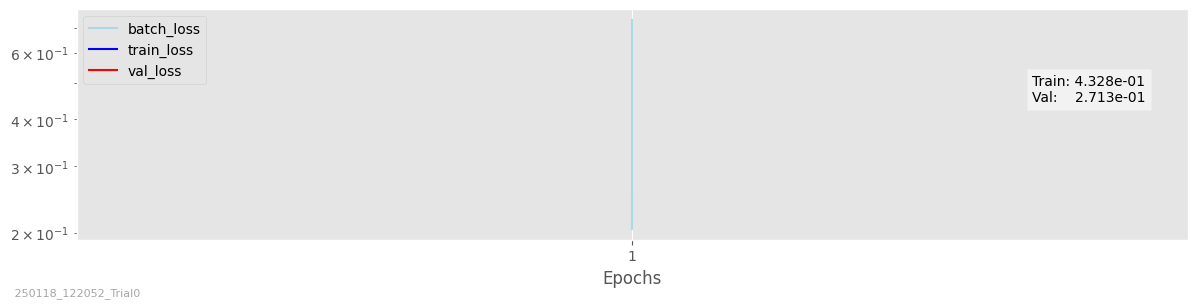

Test Loss:		0.267214
RMSE:			49.5528        
MAE ± STD (MAPE):	48.3958 ± 10.6457 (95.40%)
R-squared:		-4.3876
------------------------------------------------------------


[I 2025-01-18 12:24:38,136] Trial 0 finished with value: 48.39580154418945 and parameters: {'HIDDEN_SIZE': 60, 'NUM_LAYERS': 2, 'DROPOUT': 0.15000000000000002, 'CLIP_GRAD': 0.1, 'WEIGHT_INIT_TYPE': 'default', 'OPTIMIZER': 'adam', 'LEARNING_RATE': 0.0001, 'WEIGHT_DECAY': 1e-05}. Best is trial 0 with value: 48.39580154418945.


RMSE:			49.7563        
MAE ± STD (MAPE):	49.2423 ± 6.3152 (95.36%)
R-squared:		-234.6259
------------------------------------------------------------
Trial 0 completed.
All completed trials (sorted by value):
  Trial 0: Value: 48.39580154418945, Params: {'HIDDEN_SIZE': 60, 'NUM_LAYERS': 2, 'DROPOUT': 0.15000000000000002, 'CLIP_GRAD': 0.1, 'WEIGHT_INIT_TYPE': 'default', 'OPTIMIZER': 'adam', 'LEARNING_RATE': 0.0001, 'WEIGHT_DECAY': 1e-05}
------------------------------------------------------------
 LSTM1_packed_old_version(
  (lstm): LSTM(37, 50, num_layers=5, batch_first=True, dropout=0.25)
  (dropout_layer): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=50, out_features=25, bias=True)
  (bn1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
) ------------------------------------------------------------
Model state_dict:
---------------------------------------------

Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/165 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:01:44
------------------------------------------------------------

Trial 1


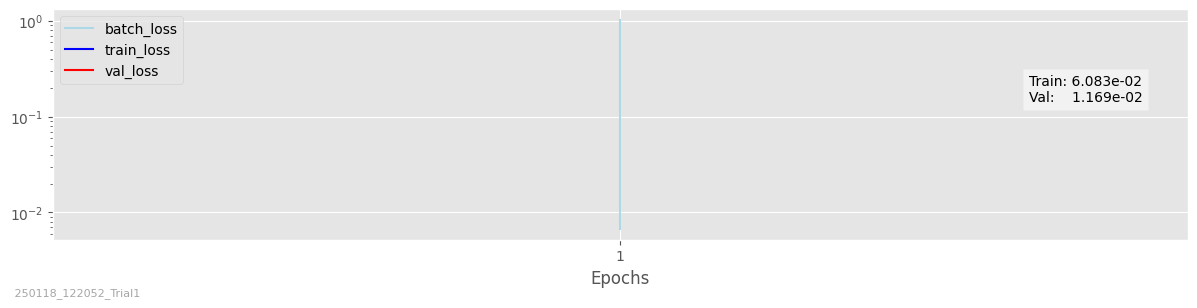

Test Loss:		0.011104
RMSE:			10.2293        
MAE ± STD (MAPE):	8.9481 ± 7.9343 (16.86%)
R-squared:		0.7704
------------------------------------------------------------


[I 2025-01-18 12:26:29,971] Trial 1 finished with value: 8.94813346862793 and parameters: {'HIDDEN_SIZE': 50, 'NUM_LAYERS': 5, 'DROPOUT': 0.25, 'CLIP_GRAD': 0.1, 'WEIGHT_INIT_TYPE': 'he', 'OPTIMIZER': 'adam', 'LEARNING_RATE': 0.002, 'WEIGHT_DECAY': 0.0}. Best is trial 1 with value: 8.94813346862793.


RMSE:			10.1361        
MAE ± STD (MAPE):	9.4226 ± 4.2907 (16.90%)
R-squared:		-10.3131
------------------------------------------------------------
Trial 1 completed.
All completed trials (sorted by value):
  Trial 1: Value: 8.94813346862793, Params: {'HIDDEN_SIZE': 50, 'NUM_LAYERS': 5, 'DROPOUT': 0.25, 'CLIP_GRAD': 0.1, 'WEIGHT_INIT_TYPE': 'he', 'OPTIMIZER': 'adam', 'LEARNING_RATE': 0.002, 'WEIGHT_DECAY': 0.0}
  Trial 0: Value: 48.39580154418945, Params: {'HIDDEN_SIZE': 60, 'NUM_LAYERS': 2, 'DROPOUT': 0.15000000000000002, 'CLIP_GRAD': 0.1, 'WEIGHT_INIT_TYPE': 'default', 'OPTIMIZER': 'adam', 'LEARNING_RATE': 0.0001, 'WEIGHT_DECAY': 1e-05}


In [10]:
# OPTUNA: STUDY -------------------------------------------------------------------
study = optuna.create_study(direction='minimize', sampler = optuna.samplers.TPESampler())    # TPESampler, RandomSampler, GridSampler, CmaEsSampler, NSGAIISampler
study.optimize(objective, n_trials=N_TRIALS, callbacks=[print_completed_trials_sorted])

___
SAVE CHECKPOINT

In [11]:
# Save the best trial config to a text file
best_trial = study.best_trial
best_trial_dict = {'params': best_trial.params, 'value': best_trial.value}
with open(Path(LOG_FILE_NAME).with_name(f"{TS}_BEST_IS_{best_trial.number}.txt"), 'w') as f: json.dump(best_trial_dict, f, indent=4)
print("Best Trial: ", best_trial.number); print("Best hyperparameters: ", study.best_params)
trials_df = study.trials_dataframe()
sorted_df = trials_df.sort_values(by=trials_df.columns[1], ascending=True)
print(tabulate(trials_df, headers='keys', tablefmt='psql'))
sorted_df.to_csv(Path(LOG_FILE_NAME).with_name(f"trials_overview.csv"), index=False)

Best Trial:  1
Best hyperparameters:  {'HIDDEN_SIZE': 50, 'NUM_LAYERS': 5, 'DROPOUT': 0.25, 'CLIP_GRAD': 0.1, 'WEIGHT_INIT_TYPE': 'he', 'OPTIMIZER': 'adam', 'LEARNING_RATE': 0.002, 'WEIGHT_DECAY': 0.0}
+----+----------+----------+----------------------------+----------------------------+------------------------+--------------------+------------------+----------------------+------------------------+---------------------+--------------------+-----------------------+---------------------------+------------------+-----------------------+-------------------+------------------------+-------------------+------------------------+----------------------+---------------------------+----------+
|    |   number |    value | datetime_start             | datetime_complete          | duration               |   params_CLIP_GRAD |   params_DROPOUT |   params_HIDDEN_SIZE |   params_LEARNING_RATE |   params_NUM_LAYERS | params_OPTIMIZER   |   params_WEIGHT_DECAY | params_WEIGHT_INIT_TYPE   |   user_attrs_